In [1]:
import os
import argparse
import random
import numpy as np
import pandas as pd
from Bio import SeqIO
from torchinfo import summary  # install torchinfo 
from torch.utils.data import random_split, DataLoader
import warnings

warnings.filterwarnings("ignore")

import grelu.lightning
import grelu.visualize
import grelu.data

os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [3]:
model_params = {
    'model_type':'EnformerModel', # Type of model
    'n_tasks': 86, # Number of cell types to predict
    'crop_len':0, # No cropping of the model output
    'n_transformers': 11, # Number of transformer layers; the published Enformer model has 11
    'channels': 384, # channel,decreasing parameters of Enformer
}

train_params = {
    'task':'regression', # binary, multiclass, or regressionn
    'loss': 'poisson',
    'lr':1e-4, # learning rate
    'logger': 'csv', # Logs will be written to a CSV file
    'batch_size': 4,
    'num_workers': 2,
    'devices': 0, # GPU index
    'save_dir': "tutorial_enformer",
    'optimizer': 'adam',
    'max_epochs': 10,
    'checkpoint': True, # Save checkpoints
    'train_label_len ': 86,
    'train_seq_len': 196608
}


In [ ]:
mmc2_gene_sequence_file   = "/geniusland/home/liuxianliang1/code/z_test_demo/Heidelberg/data/mmc2_gene_sequence.fasta"
mmc2_gene_expression_file = "/geniusland/home/liuxianliang1/code/z_test_demo/Heidelberg/data/mmc2_gene_expression_minmax_transformed.npy"

# load gene expression
mmc2_gene_expression = np.load(mmc2_gene_expression_file, allow_pickle=True)
mmc2_gene_expression_dict = dict(zip(mmc2_gene_expression.item()["genes"], mmc2_gene_expression.item()["expression"]))

# load gene sequence
mmc2_gene_sequence_dict = {}
for record in SeqIO.parse(mmc2_gene_sequence_file, "fasta"):
    gene_id = record.id  # gene ID
    gene_sequence = str(record.seq)  
    mmc2_gene_sequence_dict[gene_id] = gene_sequence

model = grelu.lightning.LightningModel(model_params, train_params)

from torchinfo import summary  
summary(model, input_size=(1, 4, 196608))

Layer (type:depth-idx)                                            Output Shape              Param #
LightningModel                                                    [1, 86, 1]                --
├─EnformerModel: 1-1                                              [1, 86, 1]                --
│    └─EnformerTrunk: 2-1                                         [1, 768, 1536]            --
│    │    └─EnformerConvTower: 3-1                                [1, 384, 1536]            3,668,096
│    │    └─EnformerTransformerTower: 3-2                         [1, 384, 1536]            14,372,864
│    │    └─ConvBlock: 3-3                                        [1, 768, 1536]            296,448
│    │    └─Activation: 3-4                                       [1, 768, 1536]            --
│    │    └─Crop: 3-5                                             [1, 768, 1536]            --
│    └─ConvHead: 2-2                                              [1, 86, 1]                --
│    │    └─ChannelTransf

In [4]:
# gene_ids = list(mmc2_gene_expression_dict.keys())[:5]
# sequences = [mmc2_gene_sequence_dict[gene_id] for gene_id in gene_ids]
# expressions = [mmc2_gene_expression_dict[gene_id] for gene_id in gene_ids]

# values = expressions[1]

# modified_values = []

# for value in values:
#     percentage_change = random.uniform(-0.5, 0.5)
#     modified_value = value * (1 + percentage_change)
#     modified_values.append(modified_value)

# real_pre_pairs = []
# real_pre_pairs.append([expressions[1], modified_values])
# real_pre_pairs = np.array(real_pre_pairs)
# for index in range(1):
#     fig = grelu.visualize.plot_tracks(
#         real_pre_pairs[index, :, :], # Outputs to plot
#         start_pos=0, # Start coordinate for the x-axis label
#         end_pos=86, # End coordinate for the x-axis label
#         titles=['real', 'pre'], # titles for each track
#         figsize=(10, 6), # width, height
#     )

In [ ]:
gene_ids = list(mmc2_gene_expression_dict.keys())[:600]
sequences = [mmc2_gene_sequence_dict[gene_id] for gene_id in gene_ids]
expressions = [mmc2_gene_expression_dict[gene_id] for gene_id in gene_ids]

predict_values = []

real_pre_pairs = []

for index, sequence in enumerate(sequences):
    if max(expressions[index]) > 0.1:
           continue
    pre_expression = model.predict_on_seqs(sequence, device=0)
    pre_expression = np.squeeze(pre_expression) / 100.0
    real_pre_pairs.append([expressions[index], pre_expression])

real_pre_pairs = np.array(real_pre_pairs)

for index in range(2):
    fig = grelu.visualize.plot_tracks(
        real_pre_pairs[index, :, :], # Outputs to plot
        start_pos=0, # Start coordinate for the x-axis label
        end_pos=86, # End coordinate for the x-axis label
        titles=['real', 'pre'], # titles for each track
        figsize=(10, 6), # width, height
    )


In [6]:
real_column = []
fake_column = []

# 遍历 real_pre_pairs
for pair in real_pre_pairs:
    # pair[0] 和 pair[1] 的每一列分别拼接
    real_column.extend(pair[0])  # 提取第一列（真实值）
    fake_column.extend(pair[1])  # 提取第二列（预测值）

# 转为一维数组
first_column = np.array(real_column)
fake_column = np.array(fake_column)

In [ ]:
from scipy.stats import spearmanr

# 计算 Spearman 相关系数
correlation, p_value = spearmanr(real_column, fake_column)
print(correlation, p_value)

0.15076260361759578 3.0129131955897917e-258


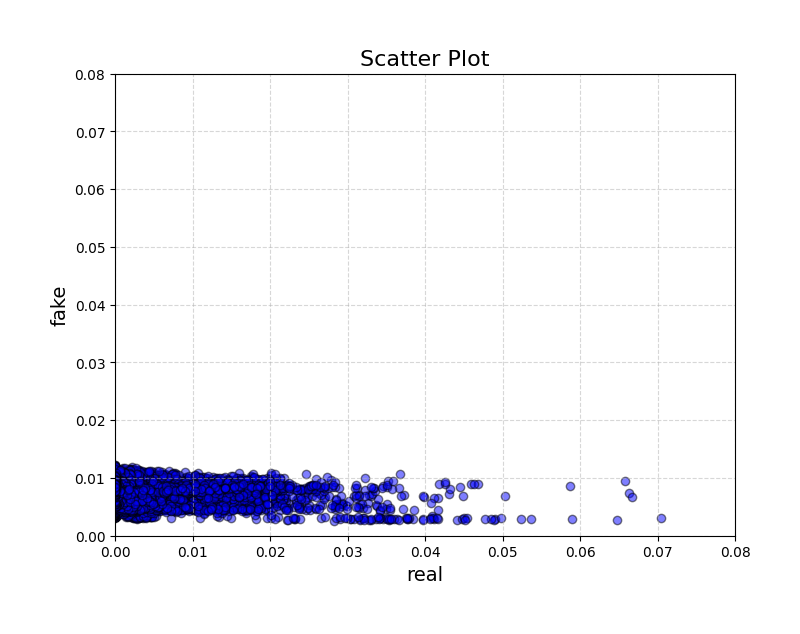

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.scatter(real_column, fake_column, color="blue", alpha=0.5, edgecolor="k")

# 添加标题和标签
plt.title("Scatter Plot", fontsize=16)
plt.xlabel("real", fontsize=14)
plt.ylabel("fake", fontsize=14)
plt.xlim(0, 0.08)  # 根据数据范围手动调整
plt.ylim(0, 0.08)  # 同步范围
# 显示网格
plt.grid(True, linestyle='--', alpha=0.5)

# 展示图像
plt.show()

In [9]:
import torch
target = torch.randn(5, 2)
print(target)

tensor([[ 0.9830, -0.5011],
        [ 0.9675,  0.8368],
        [ 0.8066, -0.1570],
        [-0.0581,  1.1329],
        [-1.1503,  1.1063]])


In [10]:
import numpy as np
expression_values = [[1,1,1], [2,2,2], [3,3,3]]
expression_values = np.array(expression_values)
column_means = np.mean(expression_values, axis=0)  # mean of each column 
column_stds = np.std(expression_values, axis=0)    # standard deviation of each column 

column_min = np.min(expression_values, axis=0)
column_max = np.max(expression_values, axis=0)

expression_values_minmax = (expression_values - column_min) / (column_max - column_min)

print(expression_values_minmax)

[[0.  0.  0. ]
 [0.5 0.5 0.5]
 [1.  1.  1. ]]
